In [1]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import seaborn as sns

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDPs

## No lead times

In [2]:

# Function to create transition probability function
def create_P(demand_distribution):
    def prob_trans(s, a, sp):
        ''' Calculates the probability of transition from state s to s' under action a'''
        demand = s + a - sp
        return demand_distribution.get(demand, 0)

    return prob_trans

# Function to create reward function given demand distribution and cost parameters
def create_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s'''
        holding_cost = hold_cost*(sum(max(s + a - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s - a, 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function

# Function to calculate Bellman's equation for a given state (depends on capacity of warehouse and state)
def value_update_func(capacity):
    def bellman_eq_no_lead(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s'''
        
        values = dict((a, 0) for a in A if s+a <= capacity) # stores value function at s for each action
        
        for a in values.keys(): # value for each action
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])
        return values
    return bellman_eq_no_lead




In [3]:

capacity = 1000

S = set(int(x) for x in np.arange(-capacity, capacity+1, 100))
A = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100))   # (multiples of 100)
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}     # demand distribution
ch = 1                                         # holding costs
cb = 100                                       # backlog costs (underage)
cs = 0                                         # ordering/shipping costs
P = create_P(demand_dist)                      # probability of transition
R = create_R(demand_dist, ch, cb, cs)          # cost function
V_init = dict([(s, 0) for s in S])             # initial costs at all states is 0
gamma=0.999                                    # discount factor for value iteration
bellman_eq_no_lead = value_update_func(capacity)


# Calculate and store results
results_no_lead = value_iteration(S=S, A=A, P=P, R=R, gamma=0.999, max_iterations=100, 
                          bellman_eq=bellman_eq_no_lead, V_init=V_init, theta=1e-7)

optimal_policy_no_lead = results_no_lead["optimal_policy"]  
cost_function_no_lead = results_no_lead["value_function"]



In [4]:
max(A)

500

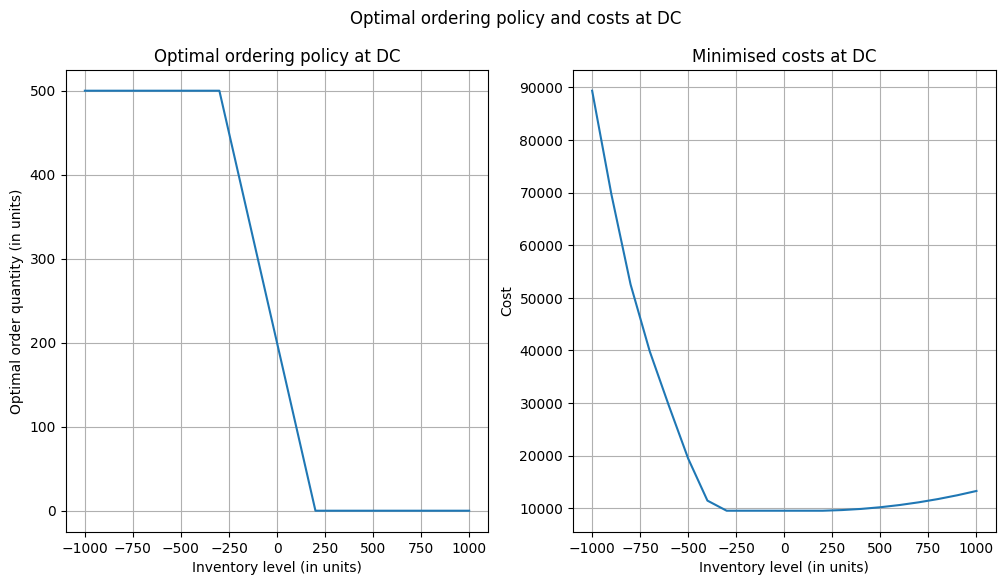

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(*zip(*sorted(optimal_policy_no_lead.items())))
ax[0].set(title="Optimal ordering policy at DC", xlabel="Inventory level (in units)", 
ylabel = "Optimal order quantity (in units)")
ax[0].grid()
ax[1].plot(*zip(*sorted(cost_function_no_lead.items())))
ax[1].set(title="Minimised costs at DC", xlabel="Inventory level (in units)", 
ylabel = "Cost")
ax[1].grid()
plt.suptitle("Optimal ordering policy and costs at DC")
plt.savefig(f"Figures/Optimal_policy_cost_no_lead_time_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with lead times

In [6]:
# Function to create transition probability function
def create_lead_P(demand_distribution):
    def prob_trans(s, a, sp):
        ''' Calculates the probability of transition from state s to s' under action a'''
        prob = 0
        if sp[1:] == (a,) + s[1:-1]: # check updated orders yet to arrive in new state
            demand = s[0] + s[-1] - sp[0]  # demand in time period
            prob = demand_distribution.get(demand, 0) 
        
        return prob
    
    return prob_trans

# Function to create the cost function given demand distribution and cost parameters
def create_lead_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s'''
        holding_cost = hold_cost*(sum(max(s[0] + s[-1] - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s[0] - s[-1], 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function

# Function to calculate Bellman's equation for a given state (depends on capacity of warehouse and state)
def lead_value_update_func(capacity):
    def bellman_eq_lead(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s'''
        
        values = dict((a, 0) for a in A if sum(s)+a <= capacity) # stores value function at s for each action
        if not values: # if inventory position > capacity, then no units to be ordered
            values = {0: 0}
        
        for a in values.keys():
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])
        return values
    return bellman_eq_lead

In [7]:
capacity = 1000
order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100))        # set of possible order quantities
inventory_set = set(int(x) for x in np.arange(-capacity, capacity + 1, 100))       # set of possible inventory levels
lead_time = 2                                                                      # lead time

# State space and action space
S = set((inv, *arriving_order) for inv in inventory_set for arriving_order in itertools.product(order_set, repeat=lead_time))
A = order_set
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}   # demand distribution
ch = 1                                       # holding cost
cb = 100                                     # backlog cost
cs = 0                                       # shipping/ordering costs
P = create_lead_P(demand_dist)               # transition probability function
R = create_lead_R(demand_dist, ch, cb, cs)   # cost function
V_init = dict([(s, 0) for s in S])           # initial cost is 0 for all states
gamma=0.999                                  # discount factor
bellman_eq_lead = lead_value_update_func(capacity)

# Run and store results from value iteration
lead_results= value_iteration(S=S, A=A, P=P, R=R, gamma=gamma, max_iterations=100, 
                          bellman_eq=bellman_eq_lead, V_init=V_init, theta=1e-7)
lead_optimal_policy = lead_results["optimal_policy"]
lead_cost_function = lead_results["value_function"]

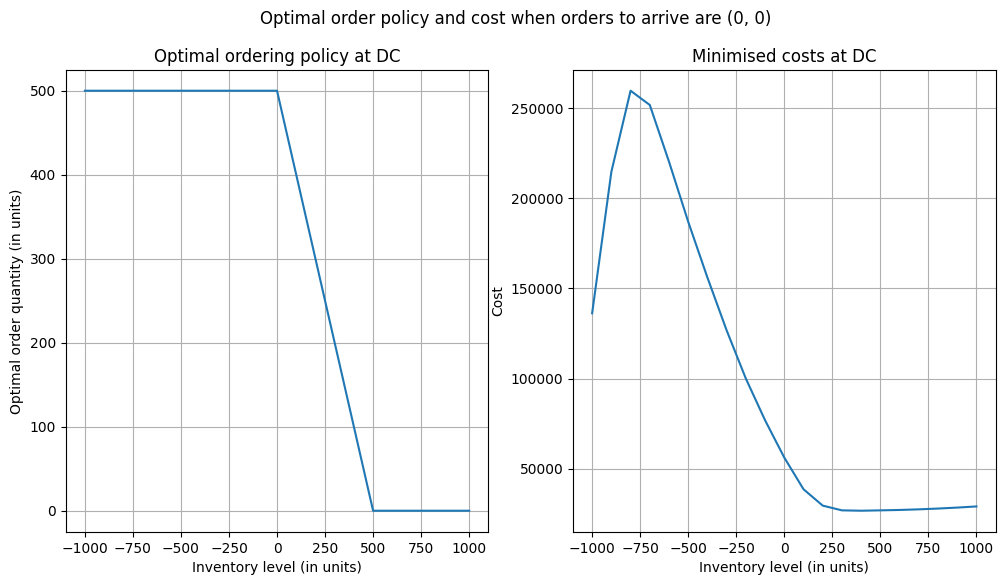

In [8]:
# possible_lead_orders = set(itertools.product(order_set, repeat=lead_time))

# Function to plot cost or policy vs inventory level given a possible combination of orders are due to arrive
def plot_per_lead_order(optimal_policy, cost_function, possible_lead_order):
    # # If inventory level = x_t + q_{t-L}
    # eligible_keys = [key for key in sorted(optimal_policy) if key[1:-1] == possible_lead_order]
    # inv_levels = [key[0]+key[-1] for key in eligible_keys]
    # opt_policy = [optimal_policy[key] for key in eligible_keys]
    # opt_cost = [cost_function[key] for key in eligible_keys]

    # If inventory level = x_t
    eligible_keys = [key for key in sorted(optimal_policy) if key[1:] == possible_lead_order]
    inv_levels = [key[0] for key in eligible_keys]
    opt_policy = [optimal_policy[key] for key in eligible_keys]
    opt_cost = [cost_function[key] for key in eligible_keys]

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    # Plot optimal policy vs inventory position
    ax[0].plot(inv_levels, opt_policy)
    ax[0].set(title = "Optimal ordering policy at DC", xlabel="Inventory level (in units)", ylabel="Optimal order quantity (in units)")
    ax[0].grid()

    # Plot cost vs inventory position
    ax[1].plot(inv_levels, opt_cost)
    ax[1].set(title = "Minimised costs at DC", xlabel="Inventory level (in units)", ylabel="Cost")
    ax[1].grid()
    plt.suptitle(f"Optimal order policy and cost when orders to arrive are {possible_lead_order}")
    plt.savefig(f"Figures/Optimal_policy_cost_ordersonway_{possible_lead_order}_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
    plt.show()

plot_per_lead_order(lead_optimal_policy, lead_cost_function, (0,0))
    

In [9]:
# All possible inventory positions
inventory_positions = set(sum(key) for key in lead_optimal_policy)
opt_policy_range = dict([(k, set()) for k in inventory_positions])        # dictionary storing ordering policy values for each inventory position
opt_cost_range = dict([(k, set()) for k in inventory_positions])      # dictionary storing minimised costs for each inventory position
for inv_pos in inventory_positions: # for each possible inventory position
    for key, policy in lead_optimal_policy.items():
        if sum(key) == inv_pos:
            opt_policy_range[inv_pos].add(policy) # add unique policies
    for key, cost in lead_cost_function.items():
        if sum(key) == inv_pos:
            opt_cost_range[inv_pos].add(cost)     # add unique costs


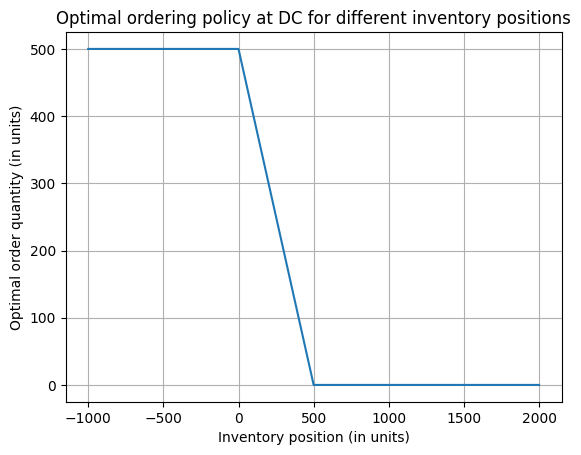

In [10]:
# Plot optimal ordering policy vs inventory position
plt.plot(*zip(*sorted([(ip, pol) for ip, pol_set in opt_policy_range.items() for pol in pol_set])))
plt.title("Optimal ordering policy at DC for different inventory positions")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Optimal order quantity (in units)")
plt.grid()
plt.savefig(f"Figures/Optimal_policy_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()



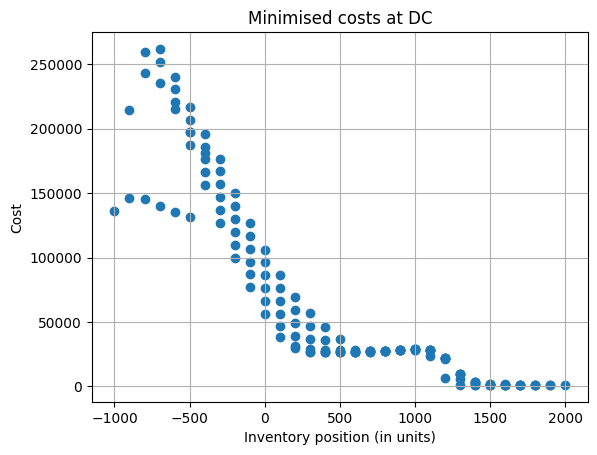

In [11]:
# Plot minimised costs vs inventory position
plt.scatter(*zip(*sorted([(ip, cost) for ip, cost_set in opt_cost_range.items() for cost in cost_set])))
plt.title("Minimised costs at DC")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()

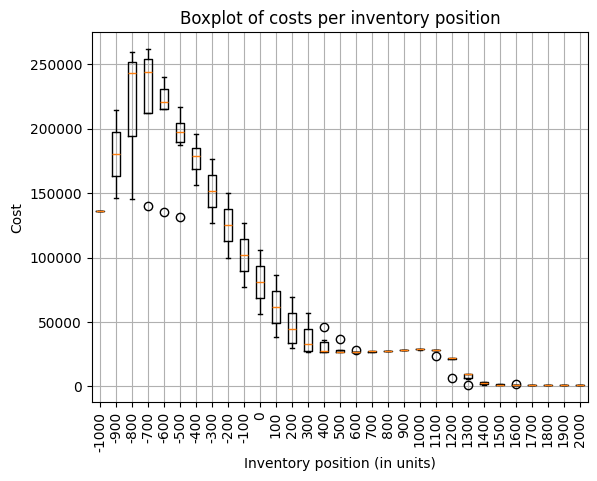

In [12]:
sorted_keys_costs = sorted(opt_cost_range.keys())
sorted_cost_values = [list(opt_cost_range[key]) for key in sorted_keys_costs]
plt.boxplot(sorted_cost_values, tick_labels=sorted_keys_costs)
plt.title("Boxplot of costs per inventory position")
plt.xlabel("Inventory position (in units)")
plt.xticks(rotation=90)
plt.ylabel("Cost")
plt.grid(True)
plt.savefig(f"Figures/Min_cost_boxplot_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()

In [13]:
# Storing inventory position, level, on hand stock, backorders, outstanding orders and the associated policies+costs for each state
ips = []
on_hand_stocks = []
backorders = []
outstanding_stocks = []
policies = []
costs = []

for s in S:
    ips.append(sum(s))
    on_hand_stocks.append(max(s[0]+s[-1], 0))
    backorders.append(max(-(s[0]+s[-1]), 0))
    outstanding_stocks.append(sum(s[1:-1]))
    policies.append(lead_optimal_policy[s])
    costs.append(lead_cost_function[s])



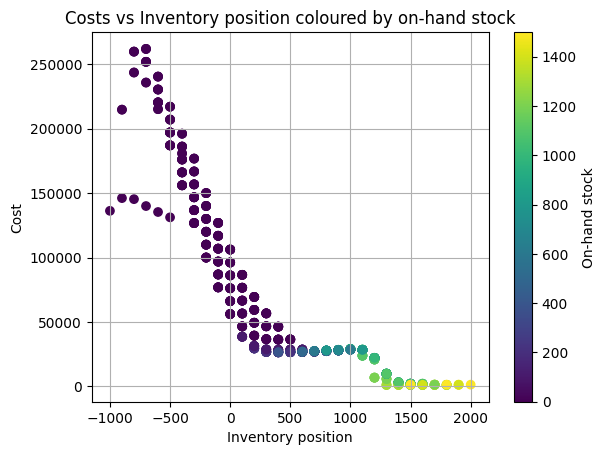

In [14]:
# Plot costs vs inventory position highlighting differences in on-hand stock
scatter = plt.scatter(ips, costs, c=on_hand_stocks, cmap='viridis')
plt.colorbar(scatter, label='On-hand stock')
plt.xlabel('Inventory position')
plt.ylabel('Cost')
plt.title('Costs vs Inventory position coloured by on-hand stock')
plt.grid(True)
plt.savefig(f"Figures/Min_cost_onhand_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()

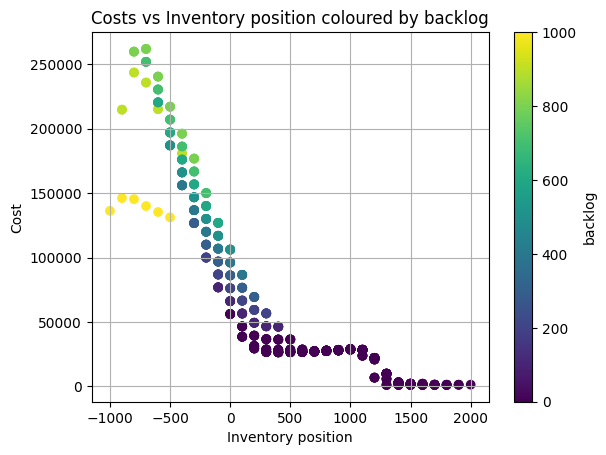

In [15]:
# Plot costs vs inventory position highlighting differences in backlogs
scatter = plt.scatter(ips, costs, c=backorders, cmap='viridis')
plt.colorbar(scatter, label='backlog')
plt.xlabel('Inventory position')
plt.ylabel('Cost')
plt.title('Costs vs Inventory position coloured by backlog')
plt.grid(True)
plt.savefig(f"Figures/Min_cost_backlog_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()

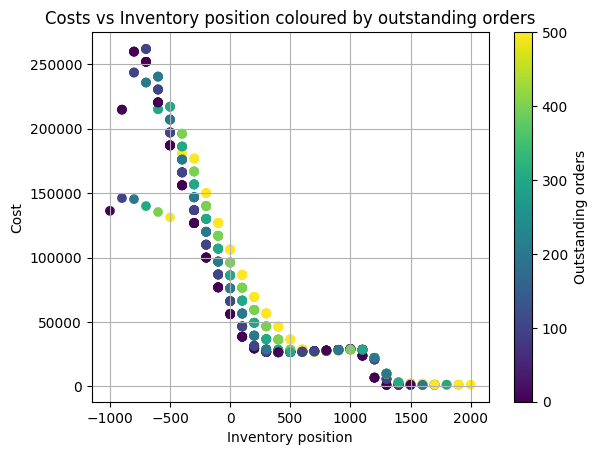

In [16]:
# Plot costs vs inventory position highlighting differences in outstanding orders
scatter = plt.scatter(ips, costs, c=outstanding_stocks, cmap='viridis')
plt.colorbar(scatter, label='Outstanding orders')
plt.xlabel('Inventory position')
plt.ylabel('Cost')
plt.title('Costs vs Inventory position coloured by outstanding orders')
plt.grid(True)
plt.savefig(f"Figures/Min_cost_outstanding_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
plt.show()

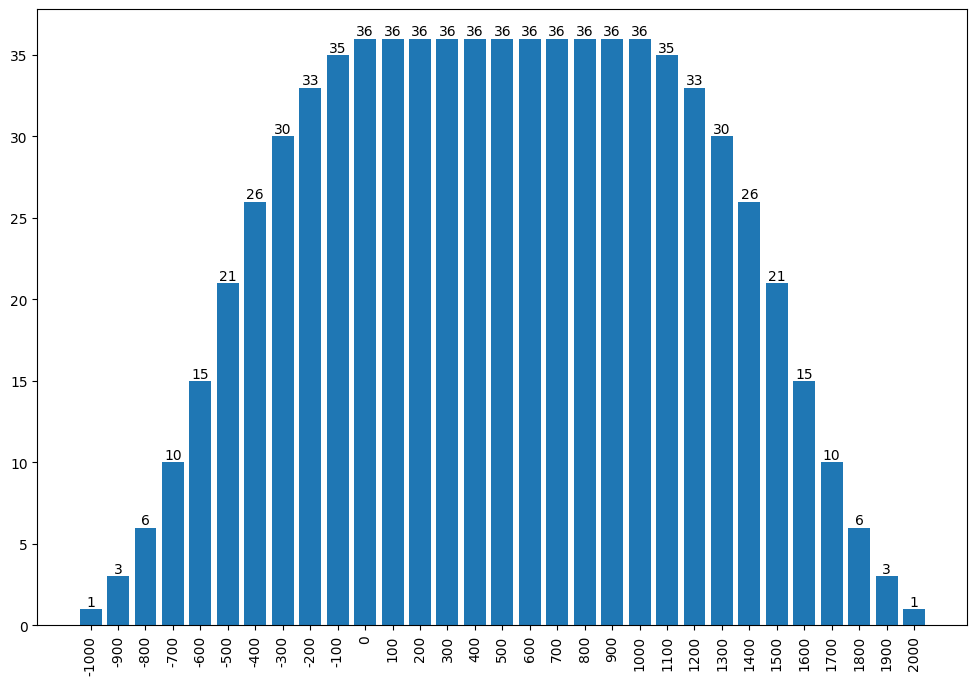

In [ ]:
ip_unique = list(sorted(inventory_positions))
ip_counts = [ips.count(value) for value in ip_unique]
plt.subplots(figsize=(12,8))
ip_bar = plt.bar(range(len(ip_unique)), ip_counts, tick_label=ip_unique)
plt.bar_label(ip_bar, ip_counts, label_type="edge")
plt.xticks(rotation=90)
plt.show()



In [21]:
ip_state = {(sum(state),) + state for state in S}

for elem in ip_state: 
    if elem[0] == 2000:
        print(f"{elem[1:]} costs: {lead_cost_function[elem[1:]]}")

(1000, 500, 500) costs: 1400.0
